In [1]:
import os
import sys
project_dir = os.path.join(os.pardir, os.pardir)
sys.path.append(project_dir)

import pandas as pd
import numpy as np
import pulp
import time
from IPython.display import display
from shapely.geometry import Polygon

In [2]:
#Data reading and cleaning
df_sectors = pd.read_csv(project_dir + "/data/external/od/setores_censitarios_CSV.csv",
                         encoding="latin-1")
df_sectors.WKT = df_sectors.WKT.str.replace("POLYGON", "")
df_sectors.WKT = df_sectors.WKT.str.replace("\(", "")
df_sectors.WKT = df_sectors.WKT.str.replace("\)", "")
df_sectors.WKT = df_sectors.WKT.str.strip()

#Extract coordinates from string
df_sectors["coords"] = df_sectors.WKT.str.split(",")
df_sectors.coords = df_sectors.coords.apply(lambda x: [tuple(map(float, i.split(" "))) for i in x])

#Create shapely Polygon
df_sectors["polygon"] = df_sectors.coords.apply(lambda x: Polygon(x))

#Get polygon area
df_sectors["area"] = df_sectors.polygon.apply(lambda x: x.area)

#Check data
print(len(df_sectors), "rows")
print(df_sectors.objectid.nunique(), "objectids")

#Drop unused columns and index with cd_geocodi
df_sectors = df_sectors[["cd_geocodi", "tipo", "nm_bairro", "polygon", "area"]]
df_sectors.set_index("cd_geocodi", inplace=True, verify_integrity=True)

df_sectors.head()

730 rows
730 objectids


,tipo,nm_bairro,polygon,area
cd_geocodi,,,,
420910205000157,URBANO,Nova Brasília,"POLYGON ((712952.1411 7085390.3829, 713025.628...",1.869259e+05
420910205000158,URBANO,Nova Brasília,"POLYGON ((712792.4804 7085600.7155, 712956.814...",3.038262e+05
420910205000159,URBANO,Nova Brasília,"POLYGON ((712088.8612 7085780.435, 712102.1324...",5.428793e+05
420910205000160,URBANO,Nova Brasília,"POLYGON ((712445.1203 7085003.5311, 712818.006...",2.844532e+06
420910205000162,URBANO,São Marcos,"POLYGON ((710085.5298 7089374.0183, 710384.236...",2.165143e+06


 Number of Equipments and Census Zones:

In [3]:
sector_list = df_sectors.index.unique().tolist()
max_setores = len(sector_list)
print("Initial number of sectors: ",max_setores)

df_equip = pd.read_csv(project_dir + "/data/interim/od/avg_per_quarter_815.csv")
df_equip.drop(df_equip.columns[0], axis=1, inplace=True)
equip_list = df_equip["Equipamento"].unique().tolist()
max_radares = len(equip_list)
print("Initial number of radars: ", max_radares)
display(df_equip.head())


Initial number of sectors:  730
Initial number of radars:  95


,Endereco,Sentido,Equipamento,Latitude,Longitude,Horario,Numero de Faixas,Corredor,Total,total_por_faixa,weighted_avg_speed
0,Av.Dr. Albano Schultz x Rua Princesa Izabel,Norte/Sul,FS569JOI,-26.2998,-48.8424,08:00 as 08:14,2.0,1.0,470.5,235.25,27.228464
1,Rua Iririu. 1070,N/S,FS579JOI,-26.27599,-48.83419,08:00 as 08:14,2.0,0.0,426.5,213.25,43.692534
2,Rua Blumenau nº1580,Norte/Sul,FS633JOI,-26.28678,-48.84984,08:00 as 08:14,2.0,1.0,409.5,204.75,40.970551
3,Rua Marquês de Olinda. 2841,N/S,FS653JOI,-26.28913,-48.86434,08:00 as 08:14,1.0,0.0,193.0,193.00,47.129987
4,Rua Iririu 246,Norte/Sul,FS599JOI,-26.28206,-48.83903,08:00 as 08:14,2.0,1.0,381.5,190.75,30.525773


Note that several equipment have flow in two directions:

In [4]:
direction_per_equip = df_equip.groupby("Equipamento").agg({"Sentido": "count"})
direction_per_equip.sort_values("Sentido", ascending=False).head()

,Sentido
Equipamento,
FS551JOI,2
FS580JOI,2
FS583JOI,2
FS585JOI,2
FS589JOI,2


We will use the sum of the flow in both directions as weight for the allocation of Census Zones per equipment.

In [5]:
total_per_equip = df_equip.groupby("Equipamento").agg({"Total": "sum"})
total_per_equip["proporcao_fluxo"] = total_per_equip["Total"] / total_per_equip["Total"].sum()
total_per_equip["num_sectors"] = total_per_equip["proporcao_fluxo"]*max_setores
total_per_equip["num_sectors"] = total_per_equip["num_sectors"].round()
diff = round(total_per_equip["num_sectors"].sum() - max_setores)
total_per_equip.iloc[0:abs(diff), total_per_equip.columns.get_loc("num_sectors")] -= np.sign(diff)
total_per_equip["num_sectors"] = total_per_equip["num_sectors"].astype(int)
print("Number of sectors after allocation: ", total_per_equip["num_sectors"].sum())
print("Checking number of equipment: ", len(total_per_equip))
total_per_equip.head()

Number of sectors after allocation:  730
Checking number of equipment:  95


,Total,proporcao_fluxo,num_sectors
Equipamento,,,
FS551JOI,85.0,0.004230,4
FS552JOI,148.5,0.007391,5
FS555JOI,169.0,0.008411,6
FS556JOI,300.0,0.014931,11
FS557JOI,154.0,0.007665,6


Get Distance Matrix exported from QGis:

In [6]:
df_distance_matrix = pd.read_csv(project_dir + "/data/external/od/Matriz_distancias.csv", index_col=0)
df_distance_matrix.head()

,FS563JOI,FS607JOI,FS603JOI,FS573JOI,FS564JOI,FS650JOI,FS592JOI,FS586JOI,FS572JOI,FS610JOI,...,FS587JOI,FS577JOI,FS643JOI,FS614JOI,FS583JOI,FS561JOI,FS551JOI,FS652JOI,FS552JOI,FS580JOI
ID,,,,,,,,,,,,,,,,,,,,,
420910205000157,1555.348538,2078.813000,2214.474220,2230.905122,2324.336417,2513.556114,2847.362218,2935.045195,2951.610919,2973.540954,...,8655.603021,8721.982207,8774.110669,9183.149427,9315.959129,9765.764834,10072.837073,11439.761384,12696.624012,14434.885892
420910205000158,2161.843243,2577.932317,2787.289889,2371.455982,2425.207904,2537.106058,3074.921395,3280.455078,3461.909925,3505.949563,...,8877.796742,9058.381584,8822.886836,9412.738303,9587.444872,9971.873880,10394.178557,11605.777350,12441.766897,14524.548969
420910205000159,2772.289767,3207.825781,3414.882190,2871.042824,2899.679359,2956.794049,3606.756216,3865.104950,4092.075329,4137.592986,...,9371.518238,9619.627589,9189.383825,9910.101005,10110.861648,10452.514539,10945.535770,12055.346090,12505.437472,14911.613876
420910205000160,2350.004824,3251.342774,3092.235856,3838.506835,3945.407447,4151.044734,4384.608323,4337.916067,3996.385785,3937.698963,...,10123.059963,10018.738985,10383.246051,10638.743889,10714.486005,11246.449886,11386.322439,12957.404603,14283.811510,16011.897783
420910205000162,4754.545623,4377.473509,4935.131679,2837.352035,2683.377207,2365.534803,3330.050424,3982.633850,4990.237224,5164.634254,...,7562.690863,8427.181640,6588.873393,8095.960754,8505.511064,8480.149934,9565.184785,9804.474507,9073.606012,12250.738718


Build Adjacency Matrix:

In [7]:
start = time.time()
adjacency_matrix = pd.DataFrame(0, index=df_sectors.index, columns=df_sectors.index)
def build_adjacency_matrix():
    for index1,_ in df_sectors.iterrows():
        for index2,_ in df_sectors.iterrows():
            if index1 == index2:
                intersects = 1
            else:
                try:
                    intersects = int(df_sectors.loc[index1, "polygon"].intersects(df_sectors.loc[index2, "polygon"]))
                except:
                    intersects = 1 #errors are probably being caused by wrong Linestrings in adjacent Polygons                                        

            adjacency_matrix.loc[index1, index2] = intersects
            
            return adjacency_matrix
        
#adjacency_matrix = build_adjacency_matrix()
adjacency_matrix = pd.read_excel(project_dir + "/data/interim/od/adjacency_matrix.xlsx", index_col=0)
end = time.time()
elapsed_time = str(int(end-start))
print("Matrix created in " + elapsed_time + " seconds.")

adjacency_matrix.head()

Matrix created in 11 seconds.


,420910205000157,420910205000158,420910205000159,420910205000160,420910205000162,420910205000163,420910205000164,420910205000007,420910205000165,420910205000166,...,420910210000011,420910210000012,420910210000013,420910210000014,420910210000015,420910210000016,420910205000734,420910210000029,420910210000030,420910210000031
cd_geocodi,,,,,,,,,,,,,,,,,,,,,
420910205000157,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
420910205000158,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
420910205000159,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
420910205000160,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
420910205000162,0,0,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


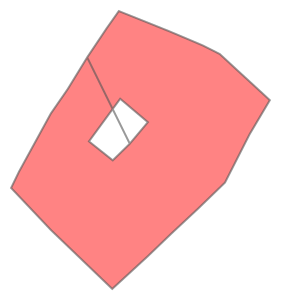

In [8]:
df_sectors.loc[420910205000341, "polygon"]

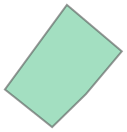

In [9]:
df_sectors.loc[420910205000737, "polygon"]

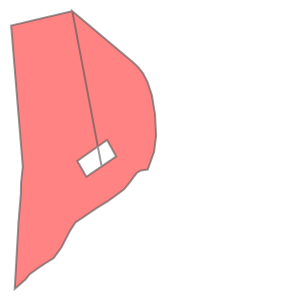

In [10]:
df_sectors.loc[420910205000458, "polygon"]

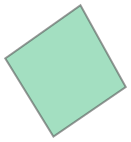

In [11]:
df_sectors.loc[420910205000459, "polygon"]

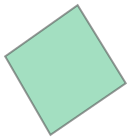

In [12]:
df_sectors.loc[420910205000608, "polygon"]

Optimization code:

In [ ]:
start = time.time()
prob = pulp.LpProblem("Designation Problem", pulp.LpMinimize)
possibleChoices = [(sector,equip) for sector in sector_list for equip in equip_list]

choice_equip_sector = pulp.LpVariable.dicts("choice",(sector_list,equip_list),0,1,pulp.LpInteger)

#objective function
objective_function = [choice_equip_sector[sector][equip]*df_distance_matrix.loc[sector,equip]
                      for (sector,equip) in possibleChoices]
prob += pulp.lpSum(objective_function)

#each sector must have at most 1 equipment
for sector in sector_list:
    vars_to_sum = [choice_equip_sector[sector][equip] for equip in equip_list]
    prob += pulp.lpSum(vars_to_sum) == 1
    
#each equipment must have at least 1 sector
for equip in equip_list:
    vars_to_sum = [choice_equip_sector[sector][equip] for sector in sector_list]
    prob += pulp.lpSum(vars_to_sum) >= 1

# #each equipment must have at most "num_sectors" sectors
# for equip in equip_list:
#     vars_to_sum = [choice_equip_sector[sector][equip] for sector in sector_list]
#     prob += pulp.lpSum(vars_to_sum) <= total_per_equip.loc[equip, "num_sectors"]
#     #prob += pulp.lpSum(vars_to_sum) <= 8

#only contiguous sectors are allowed

for j in range(0, len(sector_list)):
    for k in range(j, len(sector_list)):
        vars_to_sum = []
        for i in equip_list:
            sector1 = sector_list[j]
            sector2 = sector_list[k]
            vars_to_sum.append(choice_equip_sector[sector1][i])
            vars_to_sum.append(choice_equip_sector[sector2][i])
        prob += pulp.lpSum(vars_to_sum) <= (1 + adjacency_matrix.loc[sector1,sector2])

end = time.time()
elapsed_time = str(int(end-start))
print("Começando a resolução...", elapsed_time)
prob.solve(pulp.PULP_CBC_CMD(fracGap=0, msg=True))
print("Status: ", pulp.LpStatus[prob.status])
end = time.time()
elapsed_time = str(int(end-start))
print("Optimization run in " + elapsed_time + " seconds.")

solutions_list = []
for sector in sector_list:
    for equip in equip_list:
        if choice_equip_sector[sector][equip].value() == 1.0:
            solutions_list.append((sector, equip))

In [36]:
df_solutions = pd.DataFrame(solutions_list, columns=["Sector", "Equipment"])
print("Number of sectors after optimization: ", df_solutions["Sector"].nunique())
print("Number of radars after optimization: ", df_solutions["Equipment"].nunique())

#Cross-check on number of sectors per equipment
sectors_per_equip = df_solutions.groupby("Equipment").agg({"Sector": "count"})
sectors_per_equip = sectors_per_equip.join(total_per_equip["num_sectors"])
sectors_per_equip["diff"] = abs(sectors_per_equip["Sector"] - sectors_per_equip["num_sectors"])
total_diff = sectors_per_equip["diff"].sum()
print("Sum of the differences between actual and maximum number of sectors per radar: ", total_diff)

df_solutions.to_csv(project_dir + "/data/processed/od/optimized_sectors_per_radar_nomax_contiguous_fracgap0.csv", index=False)

Number of sectors after optimization:  730
Number of radars after optimization:  95
Sum of the differences between actual and maximum number of sectors per radar:  590
